In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)


In [2]:
df = pd.read_excel("amazon.xlsx")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [3]:
df['Review'] = df['Review'].str.lower()

In [4]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [5]:
df['Review'] = df['Review'].str.replace('\d', '')

In [9]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))


In [12]:
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Review'].head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...


,Review
0,happy
1,good quality material however panel mis-matched.
2,product fun bedroom windows.<br />imagery bit ...
3,lo unico que gustaria e que sean un poco ma la...
4,great bang buck can't believe quality material...
5,look different photo
6,exactly looking for. heavy material. great pri...
7,"looking picture, thought curtain would thinner..."
8,much whiter thought would wasn’t really expect...
9,curtain picture shows. 3rd set ambesonne curta...


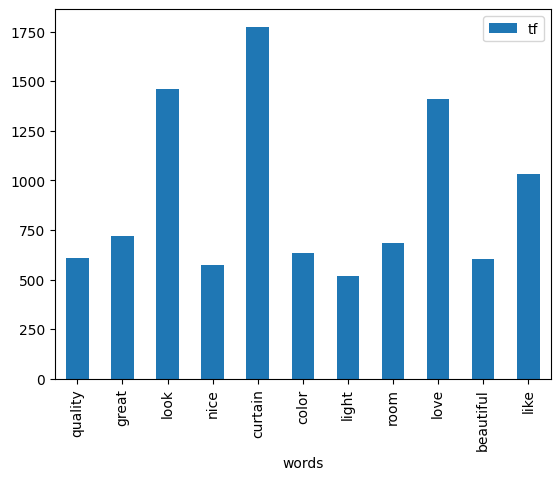

In [13]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()


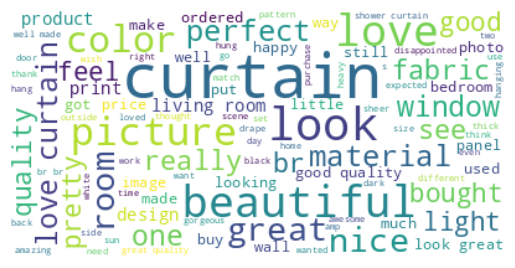

In [14]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [16]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df.groupby("Sentiment_Label")["Star"].mean()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Star
Sentiment_Label,
neg,3.45
pos,4.57


In [17]:
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)


In [18]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [19]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)


In [20]:
y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

              precision    recall  f1-score   support

         neg       0.31      0.97      0.47        72
         pos       1.00      0.89      0.94      1331

    accuracy                           0.89      1403
   macro avg       0.66      0.93      0.71      1403
weighted avg       0.96      0.89      0.91      1403



0.8538891713268937

In [21]:
random_review = pd.Series(df["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  excellent product. exactly pictured. sturdy fabric. beautiful scene. highly recommend. 
 Prediction: ['pos']


In [22]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8995068632435181